In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

# 数据准备

In [13]:
df = pd.read_csv("Corn_dat.csv")
df.head(3)

,Date,Open,High,Low,Close,Vol
0,2005/1/4,1150,1154,1143,1145,101322
1,2005/1/5,1141,1152,1141,1151,115404
2,2005/1/6,1151,1157,1151,1154,116530


In [14]:
df.shape

(4027, 6)

## 数据预处理
- 以后1000条记录作为测试集，所以预处理时仅可使用之前的数据

In [15]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
mms.fit(df.iloc[:-800][["Open", "High", "Low", "Close", "Vol"]])
df[["Open", "High", "Low", "Close", "Vol"]] = mms.transform(df[["Open", "High", "Low", "Close", "Vol"]])

In [16]:
df.describe()

,Open,High,Low,Close,Vol
count,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000
mean,0.761073,0.568585,0.758978,0.761103,0.089978
std,0.154262,0.277390,0.154109,0.154221,0.088783
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.650391,0.368939,0.648337,0.650781,0.026120
50%,0.735547,0.521434,0.733464,0.735547,0.063542
75%,0.919141,0.851019,0.918200,0.919336,0.125015
max,1.123828,1.251581,1.124070,1.125391,1.000000


### 数据集构建：[n_samples, seq_len, n_features]

In [17]:
X = []
y = []
yc = []
for i in range(30, len(df)):
    X.append(df.iloc[i-30:i, 1:6].values)
    y.append(df.iloc[i, 4])
    yc.append(1 if df.iloc[i, 4]>df.iloc[i-1, 4] else 0)
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float).view(-1, 1)
yc = torch.tensor(yc, dtype=torch.float).view(-1, 1)
X.shape, y.shape, yc.shape

C:\Users\Luan\AppData\Local\Temp\ipykernel_5976\2297038837.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:210.)
  X = torch.tensor(X, dtype=torch.float)


(torch.Size([3997, 30, 5]), torch.Size([3997, 1]), torch.Size([3997, 1]))

#### 训练集和测试集切分

In [18]:
N = -800
X_train, X_test = X[:N], X[N:]
y_train, y_test = y[:N], y[N:]
yc_train, yc_test = yc[:N], yc[N:]
trainloader = DataLoader(TensorDataset(X_train, y_train), 64, True)
trainloaderC = DataLoader(TensorDataset(X_train, yc_train), 64, True)
X_train.shape, X_test.shape

(torch.Size([3197, 30, 5]), torch.Size([800, 30, 5]))

In [19]:
writer = SummaryWriter(log_dir="runs/stockPrediction")

In [20]:
writer.add_image("test_image", torch.randn(3, 256, 256), global_step=2)

## DNN模型

In [21]:
class ModelDNN(nn.Module):
    def __init__(self, input_size, hiddens=[64, 32, 8]):
        super().__init__()
        self.hiddens = hiddens
        self.net = nn.Sequential(nn.Flatten())
        for pre, nxt in zip([input_size]+hiddens[:-1], hiddens):
            self.net.append(nn.Linear(pre, nxt))
            self.net.append(nn.ReLU())
        self.net.append(nn.Linear(hiddens[-1], 1))
        
    def forward(self, x):
        return self.net(x)

In [22]:
modelDNN = ModelDNN(30*5)
optimizer = optim.Adam(modelDNN.parameters())
criterion = nn.MSELoss()

logsDNN = {}
for i in trange(100):
    for X, y in trainloader:
        y_pred = modelDNN(X)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (i+1) % 10 ==0:
        with torch.no_grad():
            train_pred = modelDNN(X_train)
            train_mse = criterion(train_pred, y_train)
            test_pred = modelDNN(X_test)
            test_mse = criterion(test_pred, y_test)
            writer.add_scalar(tag="train_log", scalar_value=train_mse.item(), global_step=i)
            writer.add_scalar(tag="train_log", scalar_value=test_mse.item(), global_step=i)
        logsDNN[i] = {"train_mse":train_mse.item(), "test_mse":test_mse.item()}

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.54it/s]


In [23]:
writer.add_graph(model=modelDNN, input_to_model=X)

In [ ]:
pd.DataFrame(logsDNN).T.plot()

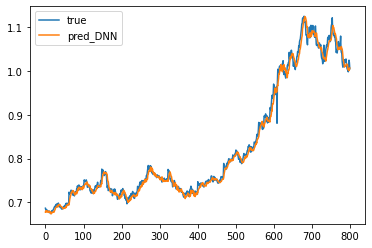

In [12]:
plt.plot(y_test, label="true")
y_pred_DNN = modelDNN(X_test).data
plt.plot(y_pred_DNN, label="pred_DNN")
plt.legend()

## CNN模型

In [24]:
class ModelCNN(nn.Module):
    def __init__(self, in_channels, hidden_channels=[8, 4]):
        # 均使用kernel=3的卷积核
        # N x C x L, L: 30->28->14->12->6
        super().__init__()
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.net = nn.Sequential()
        for in_channels, out_channels in zip([in_channels]+hidden_channels[:-1], hidden_channels):
            self.net.append(nn.Conv1d(in_channels, out_channels, kernel_size=3))
            self.net.append(nn.AvgPool1d(kernel_size=2))
        self.net.append(nn.Flatten())
        self.net.append(nn.Linear(6*hidden_channels[-1], 1))
        
    def forward(self, x):
        x = x.permute(0, 2, 1)
        return self.net(x)

In [25]:
class ModelCNNClassifier(nn.Module):
    def __init__(self, in_channels, hidden_channels=[8, 4]):
        # 均使用kernel=3的卷积核
        # N x C x L, L: 30->28->14->12->6
        super().__init__()
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.net = nn.Sequential()
        for in_channels, out_channels in zip([in_channels]+hidden_channels[:-1], hidden_channels):
            self.net.append(nn.Conv1d(in_channels, out_channels, kernel_size=3))
            self.net.append(nn.AvgPool1d(kernel_size=2))
        self.net.append(nn.Flatten())
        self.net.append(nn.Linear(6*hidden_channels[-1], 1))
        self.net.append(nn.Sigmoid())
        
    def forward(self, x):
        x = x.permute(0, 2, 1)
        return self.net(x)

In [26]:
modelCNN = ModelCNN(5)
optimizer = optim.Adam(modelCNN.parameters())
criterion = nn.MSELoss()

logsCNN = {}
for i in trange(100):
    for X, y in trainloader:
        y_pred = modelCNN(X)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (i+1) % 10 ==0:
        with torch.no_grad():
            train_pred = modelCNN(X_train)
            train_mse = criterion(train_pred, y_train)
            test_pred = modelCNN(X_test)
            test_mse = criterion(test_pred, y_test)
            print(i, train_mse.item(), test_mse.item())
        logsCNN[i] = {"train_mse":train_mse.item(), "test_mse":test_mse.item()}

 11%|████████▉                                                                        | 11/100 [00:01<00:10,  8.24it/s]

9 0.0005000036908313632 0.0003851907385978848


 21%|█████████████████                                                                | 21/100 [00:02<00:09,  7.93it/s]

19 0.0004803610790986568 0.000373680901248008


 31%|█████████████████████████                                                        | 31/100 [00:03<00:08,  7.91it/s]

29 0.0004735670518130064 0.0004133479669690132


 41%|█████████████████████████████████▏                                               | 41/100 [00:05<00:07,  7.73it/s]

39 0.0004542860551737249 0.000398518139263615


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:06<00:06,  7.79it/s]

49 0.000410682667279616 0.0003035810950677842


 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:07<00:05,  7.65it/s]

59 0.00038785571814514697 0.0002809217548929155


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [00:09<00:03,  7.90it/s]

69 0.00036612420808523893 0.00026702237664721906


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:10<00:02,  7.74it/s]

79 0.00037375398096628487 0.00031330843921750784


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [00:11<00:01,  7.29it/s]

89 0.00034130088170059025 0.00026046429411508143


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.72it/s]

99 0.0003184002125635743 0.0002218081062892452


In [29]:
writer.add_graph(model=modelCNN, input_to_model=X, verbose=True)

graph(%self.1 : __torch__.___torch_mangle_51.ModelCNN,
      %x : Float(61, 30, 5, strides=[150, 5, 1], requires_grad=0, device=cpu)):
  %net : __torch__.torch.nn.modules.container.___torch_mangle_50.Sequential = prim::GetAttr[name="net"](%self.1)
  %31 : int = prim::Constant[value=0]() # C:\Users\Luan\AppData\Local\Temp\ipykernel_5976\3051086928.py:16:0
  %32 : int = prim::Constant[value=2]() # C:\Users\Luan\AppData\Local\Temp\ipykernel_5976\3051086928.py:16:0
  %33 : int = prim::Constant[value=1]() # C:\Users\Luan\AppData\Local\Temp\ipykernel_5976\3051086928.py:16:0
  %34 : int[] = prim::ListConstruct(%31, %32, %33)
  %input.1 : Float(61, 5, 30, strides=[150, 1, 5], requires_grad=0, device=cpu) = aten::permute(%x, %34) # C:\Users\Luan\AppData\Local\Temp\ipykernel_5976\3051086928.py:16:0
  %116 : int = prim::Constant[value=-1](), scope: __module.net/__module.net.4 # C:\ProgramData\Miniconda3\lib\site-packages\torch\nn\modules\flatten.py:45:0
  %117 : int = prim::Constant[value=2](), s

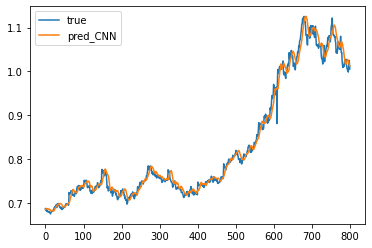

In [16]:
plt.plot(y_test, label="true")
y_pred_CNN = modelCNN(X_test).data
plt.plot(y_pred_CNN, label="pred_CNN")
plt.legend()

## RNN 模型

In [17]:
class ModelRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # 注意，这里设置batch_first=True
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.activation = nn.ReLU()
        self.output = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        _, hidden = self.gru(x)
        hidden = hidden.squeeze(0)
        hidden = self.activation(hidden)
        return self.output(hidden)

In [18]:
modelRNN = ModelRNN(5, 4)
optimizer = optim.Adam(modelRNN.parameters())
criterion = nn.MSELoss()

logsRNN = {}
for i in trange(100):
    for X, y in trainloader:
        y_pred = modelRNN(X)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (i+1) % 10 ==0:
        with torch.no_grad():
            train_pred = modelRNN(X_train)
            train_mse = criterion(train_pred, y_train)
            test_pred = modelRNN(X_test)
            test_mse = criterion(test_pred, y_test)
            print(i, train_mse.item(), test_mse.item())
        logsRNN[i] = {"train_mse":train_mse.item(), "test_mse":test_mse.item()}

 10%|████████                                                                         | 10/100 [00:04<00:42,  2.12it/s]

9 0.012753323651850224 0.016580378636717796


 20%|████████████████▏                                                                | 20/100 [00:09<00:36,  2.17it/s]

19 0.0003434719401411712 0.0027358615770936012


 30%|████████████████████████▎                                                        | 30/100 [00:13<00:32,  2.13it/s]

29 0.0002829447912517935 0.002079923404380679


 40%|████████████████████████████████▍                                                | 40/100 [00:18<00:28,  2.14it/s]

39 0.00026205528411082923 0.0017521214904263616


 50%|████████████████████████████████████████▌                                        | 50/100 [00:23<00:24,  2.05it/s]

49 0.00023914763005450368 0.0015316646313294768


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:27<00:18,  2.18it/s]

59 0.00023160388809628785 0.0013268936891108751


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:32<00:13,  2.27it/s]

69 0.00022359365539159626 0.0012075452832505107


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:36<00:09,  2.20it/s]

79 0.0002185828925576061 0.0011373759480193257


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:41<00:04,  2.09it/s]

89 0.00021677454060409218 0.0010881763882935047


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.18it/s]

99 0.00023444437829311937 0.0010813606204465032


<AxesSubplot:>

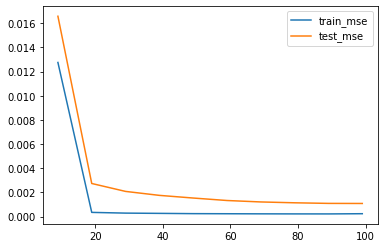

In [20]:
pd.DataFrame(logsRNN).T.plot()

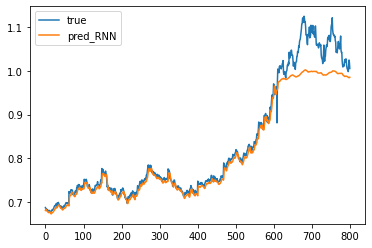

In [21]:
plt.plot(y_test, label="true")
y_pred_RNN = modelRNN(X_test).data
plt.plot(y_pred_RNN, label="pred_RNN")
plt.legend()

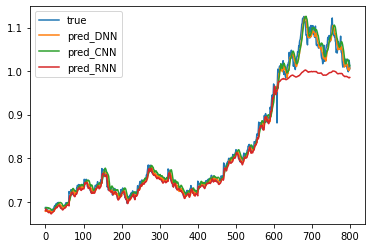

In [22]:
plt.plot(y_test, label="true")
plt.plot(y_pred_DNN, label="pred_DNN")
plt.plot(y_pred_CNN, label="pred_CNN")
plt.plot(y_pred_RNN, label="pred_RNN")
plt.legend()

In [23]:
r2_score(y_test, y_pred_DNN), r2_score(y_test, y_pred_CNN), r2_score(y_test, y_pred_RNN)

(0.9928134778867342, 0.9893679416664234, 0.9408916777359665)

In [24]:
dfDNN = pd.DataFrame(logsDNN).T.rename(columns={"train_mse":"DNN_train_mse", "test_mse":"DNN_test_mse"})
dfCNN = pd.DataFrame(logsCNN).T.rename(columns={"train_mse":"CNN_train_mse", "test_mse":"CNN_test_mse"})
dfRNN = pd.DataFrame(logsRNN).T.rename(columns={"train_mse":"RNN_train_mse", "test_mse":"RNN_test_mse"})

<AxesSubplot:>

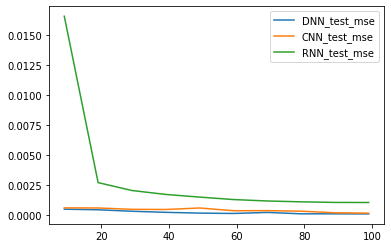

In [25]:
pd.concat((dfDNN, dfCNN, dfRNN), axis=1)[["DNN_test_mse", "CNN_test_mse", "RNN_test_mse"]].plot()